# Feature extraction

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from main import PreProcessing, Statistics
import numpy as np
import json
from scipy.stats import mode, median_abs_deviation, iqr, trim_mean, entropy as ent, skew, kurtosis
from scipy.signal import welch, correlate, stft
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from scipy.fft import fft, fftfreq
import entropy as ent

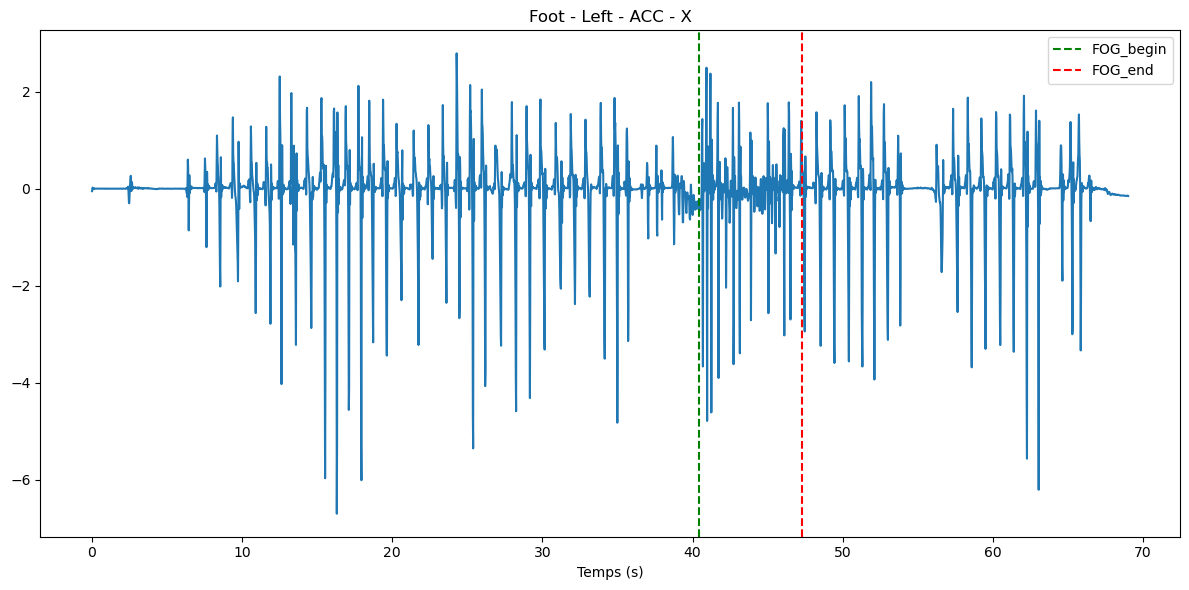

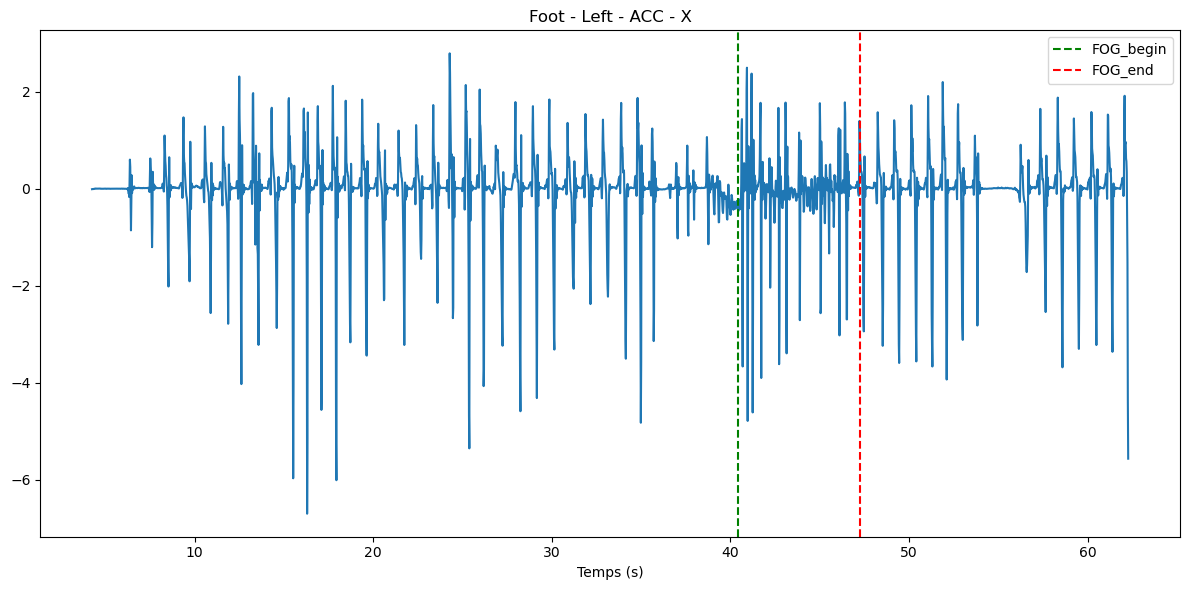

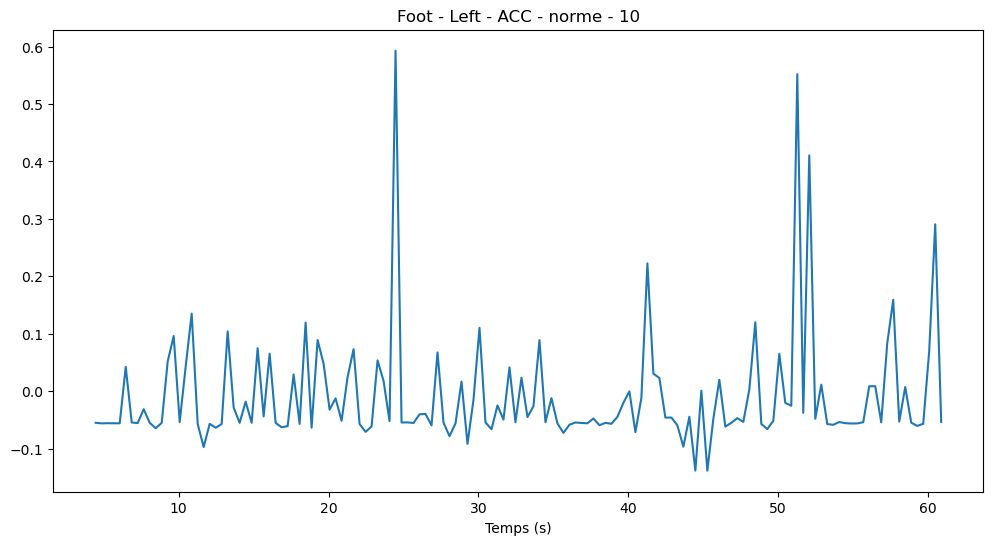

In [6]:
file_path = "C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/A_P_1956-02-21_ON_DM_1.c3d"
# file_path = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/LE_LIEVRE_Emmanuel_1971_03_19_LEEM1971/2023-05-26/2023-05-26_overlay_detectFOG/Video overlay 15.c3d"

# Instancier l'objet DetectFog
detector = PreProcessing(file_path)
detector.creation_json_grace_c3d()
detector.plot_data_FOG("Foot", "Left", "ACC", "X")

data_interval=detector.extract_data_interval()
detector.plot_data_FOG_start_end("Foot", "Left", "ACC", "X")

# detector.plot_data_FOG_start_end("Rectus Femoris", "Left", "ACC", "X")
detector.normalize_data() 
data = detector.decoupage_en_fenetres()
detector.label_fenetre()
detector.association_label_fenetre_data()
data = detector.concat_label_fenetre_data()
# detector.plot_data_FOG_start_end_final("Rectus Femoris", "Left", "ACC", "norme",10) # trouver une solution pour le temps
detector.plot_data_FOG_start_end_final("Foot", "Left", "ACC", "norme",10) # trouver une solution pour le temps



Attention le code le labelisation des fenêtre ne fonctionne pas quand il y a plusieurs FOG consécutifs ne moins de 1 ou 2 secondes

In [7]:
# a = data["Rectus Femoris"]["Left"]["ACC"]["norme"]
a = data["Foot"]["Left"]["ACC"]["X"]

# Extraction des caractéristiques

## 1. Domaine temporel

In [8]:
copie_a = a.copy()
a_moins_une_ligne = a.drop(a.index[-1]) 
a_sans_label = a_moins_une_ligne.drop(columns=["label"])
label = a["label"]
print(type(a_sans_label))
temps = data["metadata"]["temps"]

# Définir le chemin complet du fichier CSV sur votre ordinateur
chemin_fichier_excel = "C:/Users/antho/Documents/MEMOIRE_M2/data.csv"
chemin_fichier_excel_temps = "C:/Users/antho/Documents/MEMOIRE_M2/temps.csv"

# Exporter le DataFrame en tant que fichier CSV
a_sans_label.to_csv(chemin_fichier_excel, index=False)
temps.to_csv(chemin_fichier_excel_temps, index=False)

<class 'pandas.core.frame.DataFrame'>


In [19]:
chemin_fichier_excel_label = "C:/Users/antho/Documents/MEMOIRE_M2/label.csv"

# # Exporter le DataFrame en tant que fichier CSV
label.to_csv(chemin_fichier_excel_label, index=False)

### a. Entropie

In [ ]:
# # Je ne comprend trop comment la formule est appliqué, car pour appliquer Shannon nous sommes censé avoir une 
# # des valeurs discrètess. Or, dans notre cas se sont des valeurs continues.

# def shannon_entropy(signal):
#     # Calculer l'histogramme des valeurs de la signal
#     hist, _ = np.histogram(signal, bins=256, density=True)
#     hist = hist[hist > 0]  # Supprimer les valeurs nulles pour éviter les erreurs de calcul

#     # Calculer l'entropie de Shannon
#     entropy = -np.sum(hist * np.log2(hist))

#     return entropy

# entropies = a_moins_dernier_ligne.apply(shannon_entropy, axis=1)

### b. Mode

In [40]:
# t = a_moins_dernier_ligne.transpose()


# def calculate_modes(data):
#     modes = []
#     for row in data:
#         unique_values, counts = np.unique(row, return_counts=True)
#         max_count_index = np.argmax(counts)
#         mode_value = unique_values[max_count_index]
#         mode_count = counts[max_count_index]
        
#         # Vérifier si le mode a une seule occurrence
#         if mode_count == 1:
#             modes.append(0)
#         else:
#             modes.append(mode_value)
#     return modes

# # Calculer les modes pour chaque ligne
# modes_per_row = calculate_modes(a_moins_dernier_ligne)

# print("Modes per Row:", modes_per_row)

'''Etant donné la précision de nos données, nous n'avons aucunes occurance et donc le mode ne sert à rien.'''

Modes per Row: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### c. median_abs_deviation

In [32]:
medmedian_abs_deviation = median_abs_deviation(a_sans_label, axis=1, nan_policy='omit')

##### Coef autorégression avec NaN

##### Validation croisée pour déterminer le meilleur ordre

In [18]:
fenetres = [np.array(window) for window in a_sans_label.values]


In [8]:
'''Nous allons effectuer une validation croisée temporelle pour déterminer l'ordre optimal du modèle 
d'autorégression pour chaque fenêtre de données.'''

'''L'ordre correspond au nombre de valeurs précédentes à utiliser pour prédire la valeur actuelle.'''

max_order = 9 # Ordre maximal du modèle AR à tester
best_orders = {}
best_mse = np.inf # Initialisation de l'erreur quadratique moyenne (MSE) minimale

# Définition de la stratégie de validation croisée temporelle
tscv = TimeSeriesSplit(n_splits=4)

# Parcours de chaque fenêtre
for i,fenetre in enumerate(fenetres):
    best_order = None
    best_mse = np.inf
    
    # Parcours des ordres possibles du modèle AR pour cette fenêtre
    for p in range(1, max_order + 1): # On commence à 1 car l'ordre 0 n'a pas de sens
        mse_scores = []
        
        # Parcours des plis de validation croisée
        for train_index, test_index in tscv.split(fenetre):
            train_data, test_data = fenetre[train_index], fenetre[test_index]
            
            # Ajustement du modèle AutoReg avec l'ordre spécifié
            model = AutoReg(train_data, lags=p)
            result = model.fit()
            
            # Prédictions sur l'ensemble de test
            predictions = result.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
            
            # Calcul de l'erreur quadratique moyenne (MSE)
            mse = mean_squared_error(test_data, predictions)
            mse_scores.append(mse)
        
        # Calcul de l'erreur quadratique moyenne (MSE) moyenne pour cet ordre
        avg_mse = np.mean(mse_scores)

        # Mise à jour de l'ordre optimal pour cette fenêtre si nécessaire
        if avg_mse < best_mse:
            best_mse = avg_mse
            best_order = p
    
    # Enregistrement de l'ordre optimal pour cette fenêtre
    best_orders[i] = best_order

# Affichage des ordres optimaux pour chaque fenêtre
print("Ordres optimaux pour chaque fenêtre :", best_orders)



Ordres optimaux pour chaque fenêtre : {0: 5, 1: 3, 2: 3, 3: 1, 4: 2, 5: 5, 6: 4, 7: 3, 8: 7, 9: 4, 10: 4, 11: 8, 12: 2, 13: 2, 14: 1, 15: 4, 16: 2, 17: 2, 18: 2, 19: 1, 20: 1, 21: 3, 22: 1, 23: 3, 24: 3, 25: 3, 26: 2, 27: 1, 28: 1, 29: 1, 30: 6, 31: 1, 32: 1, 33: 1, 34: 1, 35: 2, 36: 1, 37: 1, 38: 1, 39: 2, 40: 4, 41: 9, 42: 1, 43: 1, 44: 1, 45: 2, 46: 1, 47: 3, 48: 2, 49: 6, 50: 1, 51: 1, 52: 3, 53: 4, 54: 8, 55: 2, 56: 3, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 5, 63: 4, 64: 4, 65: 1, 66: 8, 67: 1, 68: 1, 69: 1, 70: 6, 71: 1, 72: 2, 73: 1, 74: 2, 75: 1, 76: 6, 77: 1, 78: 1, 79: 2, 80: 3, 81: 8, 82: 1, 83: 2, 84: 1, 85: 2, 86: 4, 87: 1, 88: 4, 89: 6, 90: 8, 91: 2, 92: 8, 93: 7, 94: 1, 95: 1, 96: 1, 97: 1, 98: 3, 99: 6, 100: 5, 101: 4, 102: 2, 103: 3, 104: 3, 105: 1, 106: 2, 107: 2, 108: 5, 109: 6, 110: 1, 111: 1, 112: 1, 113: 8, 114: 3, 115: 2, 116: 1, 117: 1, 118: 2, 119: 1, 120: 6, 121: 9, 122: 2, 123: 8, 124: 9}


#### Application des ordres à chaque fenêtre, pour obtenir les coef d'autorégression

In [9]:
# Liste pour stocker les coefficients d'autorégression pour chaque fenêtre
coefficients_autoreg = []
coef_data = pd.DataFrame()
# Parcours de chaque fenêtre et ajustement du modèle AR
for i, fenetre in enumerate(fenetres):
    modele_ar = AutoReg(fenetre, lags=best_orders[i])
    resultat = modele_ar.fit()
    # print(resultat)
    # Récupération des coefficients d'autorégression
    coefficients = resultat.params[best_orders[i]] # On récupère le coefficient associé à l'ordre optimal pour chaque index
    # print(resultat.params)
    coefficients_autoreg.append(coefficients)
    


#### Médiane

In [25]:
features = np.median(a_sans_label, axis=1)
print(features)

[-0.06059907 -0.05989369 -0.0567904  -0.04888659 -0.04504055 -0.05758185
 -0.04840662 -0.04828901 -0.05015977 -0.05771518 -0.0485917  -0.04510991
 -0.05807706 -0.05736857 -0.04499871 -0.0509708  -0.0581442  -0.05069057
 -0.03104776 -0.05069057 -0.05661346 -0.0402918  -0.03829353 -0.05660785
 -0.05599289 -0.04031123 -0.01511948 -0.05654827 -0.0490105  -0.03292603
 -0.04268338 -0.05814073 -0.04994507 -0.04088085 -0.05821733 -0.05820339
 -0.04029231 -0.0477245  -0.05932588 -0.05745642 -0.05750568 -0.05451007
 -0.05882741 -0.05736165 -0.0359781  -0.03337124 -0.05839036 -0.05046613
 -0.02370286 -0.05488299 -0.05682997 -0.02448565 -0.01435352 -0.055521
 -0.0242304   0.02388977 -0.02788957 -0.04725027 -0.00251365 -0.03961114
 -0.05175    -0.03961114 -0.0412554  -0.05356166 -0.04761531 -0.02377992
 -0.05448454 -0.05396679 -0.04906547 -0.05529041 -0.05536928 -0.05350335
 -0.05286937 -0.05455523 -0.04943814 -0.00329331 -0.03590751 -0.0512782
 -0.01708603 -0.01354312 -0.0504814  -0.03858338 -0.00

#### Incréments

In [20]:
    # Incréments
df_features = pd.DataFrame()
features = {}
# Incréments
# Calculer les différences entre les éléments consécutifs de chaque ligne
diffs = np.diff(a_sans_label.values, axis=1)
# Créer une matrice de zéros avec la même forme que diffs mais avec une colonne supplémentaire
zeros_column = np.zeros((diffs.shape[0], 1))
# Concaténer la matrice de zéros à gauche de la matrice diffs
diffs_with_zeros = np.concatenate((zeros_column, diffs), axis=1)
features['increments'] = diffs_with_zeros

'''Ne fonctionne pas lorsque je cherche à convertir le dictionnaire en dataframe'''

#### Corrélation Croisée entre les différentes fenêtres

In [21]:
num_windows = len(a_sans_label)
print(num_windows)

125


In [22]:
# Fonction pour calculer la corrélation croisée entre chaque paire de fenêtres
def calculate_cross_correlation_between_windows(signal_windows):
    num_windows = len(signal_windows)
    correlations = []

    for i in range(num_windows):
        for j in range(i + 1, num_windows):  # Pour éviter de calculer la corrélation de la fenêtre avec elle-même
            correlation = correlate(signal_windows[i], signal_windows[j], mode='same')
            correlations.append(correlation)

    return correlations



In [23]:
correlation_test = calculate_cross_correlation_between_windows(a_sans_label)

KeyError: 100

 # ___________________________________________________________________________________________________________________________

# Création dataframe des caractéristiques

### 1. Caractéristiques temporelles

In [14]:
aaaaaaa = np.mean(a_sans_label, axis=1)

In [4]:
import pandas as pd

def extract_temporal_features(data):
    
    # Initialise un DataFrame vide pour stocker les caractéristiques
    df_features = pd.DataFrame()
    
    # Moyenne
    df_features['Mean_Temporal'] = np.mean(data, axis=1)
    
    # Écart type
    df_features['Ecart_Type_Temporal'] = np.std(data, axis=1)
    
    # Variance
    df_features['Variance_Temporal'] = np.var(data, axis=1)
    
    # Énergie
    df_features['Energy_Temporal'] = np.sum(np.square(data), axis=1)
    
    # Range
    df_features['Range'] = np.ptp(data, axis=1)
    
    # Root mean square
    df_features['RMS'] = np.sqrt(np.mean(np.square(data), axis=1))
    
    # Médiane
    df_features['Median_Temporal'] = np.median(data, axis=1)
    
    # Trimmed mean
    df_features['Trimmed_Mean'] = trim_mean(data, 0.1, axis=1)
    
    # Mean absolute value
    df_features['Mean_Absolute_Value'] = np.mean(np.abs(data), axis=1)
    
    # Median absolute deviation
    df_features['Median_Absolute_Deviation'] = median_abs_deviation(data, axis=1, nan_policy='omit')
    
    # Percentiles
    df_features['25th_percentile'] = np.percentile(data, 25, axis=1)
    
    df_features['75th_percentile'] = np.percentile(data, 75, axis=1)
    
    # Interquantile range
    df_features['Interquartile_range'] = iqr(data, axis=1, rng=(25,75), nan_policy="omit")
    
    # Skewness
    df_features['Skewness_Temporal'] = skew(data, axis=1)
    
    # Kurtosis
    df_features['Kurtosis_Temporal'] = kurtosis(data, axis=1)
    
    # Incréments moyennes
    mean = np.mean(data, axis=1)
    df_features['Increments_Mean'] = np.diff(mean, prepend=mean[0])
    
    # Coefficients d'autorégression
    fenetres = [np.array(window) for window in data.values]
    max_order = 9
    best_orders = {}
    best_mse = np.inf 
    tscv = TimeSeriesSplit(n_splits=4)

    for i, fenetre in enumerate(fenetres):
        best_order = None
        best_mse = np.inf
    
        for p in range(1, max_order + 1):
            mse_scores = []
        
            for train_index, test_index in tscv.split(fenetre):
                train_data, test_data = fenetre[train_index], fenetre[test_index]
            
                model = AutoReg(train_data, lags=p)
                result = model.fit()
                predictions = result.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
                mse = mean_squared_error(test_data, predictions)
                mse_scores.append(mse)
        
            avg_mse = np.mean(mse_scores)

            if avg_mse < best_mse:
                best_mse = avg_mse
                best_order = p
    
        best_orders[i] = best_order

    coefficients_autoreg = []

    for i, fenetre in enumerate(fenetres):
        modele_ar = AutoReg(fenetre, lags=best_orders[i])
        resultat = modele_ar.fit()
        coefficients = resultat.params[best_orders[i]]
        coefficients_autoreg.append(coefficients) 
    df_features['Ar_Coefficients'] = coefficients_autoreg 

    # Coefficient de variation
    df_features['Coefficient_Variation'] = np.std(data, axis=1) / np.mean(data, axis=1)
    
    # Normalized signal magnitude area
    # features['normalized_signal_magnitude_area'] = np.sum(np.abs(np.diff(data, axis=1)), axis=1) / data.shape[1]
    
    # Mean crossing rate
    # features['mean_crossing_rate'] = np.mean(np.diff(data > np.mean(data, axis=1, keepdims=True), axis=1), axis=1)
    
    # Signal vector magnitude
    # features['signal_vector_magnitude'] = np.sqrt(np.sum(np.square(data), axis=1))
    
    # # Incréments
    # # Calculer les différences entre les éléments consécutifs de chaque ligne
    # diffs = np.diff(data, axis=1)
    # # Insérer une colonne de zéros au début de chaque ligne
    # features['increments'] = np.hstack((np.zeros((data.shape[0], 1)), diffs))
    # df_features['increments'] = features['increments']
    
    # Entropie
    # features['entropy'] = entropy(data, axis=1)
    
    # Pic de la transformée de Fourier (FFT)
    # f, Pxx = welch(data, axis=1)
    # features['fft_peak'] = f[np.argmax(Pxx, axis=1)]
    # df_features['fft_peak'] = features['fft_peak']

    return df_features


In [16]:
# Exemple d'utilisation
temporal_features = extract_temporal_features(a_sans_label)

In [18]:
chemin_fichier_excel_caract_temporelle = "C:/Users/antho/Documents/MEMOIRE_M2/caract_temporelles.csv"

# Exporter le DataFrame en tant que fichier CSV
temporal_features.to_csv(chemin_fichier_excel_caract_temporelle, index=False)

### 2. Caractéristiques fréquentielles

#### Classique

In [9]:
def transformation_domaine_frequentiel (data, fs = 50):
    # Nombre de points de données par fenêtre
    n = a_sans_label.shape[1]  # ou 100 si c'est connu

    # Créer un tableau de fréquences
    frequences = fftfreq(n, d=1/fs)
    frequences = frequences[:n//2] # obligé de laisser la data en série, pour générer le graphique des spectres de magnitudes
    frequencies = fftfreq(n, d=1/fs)
    frequencies = frequencies[:n//2]

    # Transposer le tableau de fréquences pour le mettre en colonnes
    frequencies = frequencies.reshape((1, -1))



    # calculer la transformée de Fourier
    fft_result = fft(a_sans_label, axis = 1)
    fft_magnitudes = np.abs(fft_result)[:,:n//2] # Garder uniquement les valeurs positives, puisque d'après la symétrie de la FFT, les valeurs négatives sont les mêmes que les valeurs positives



    # chemin_fichier_excel_mag = "C:/Users/antho/Documents/MEMOIRE_M2/magnitude_frequence.csv"
    # chemin_fichier_excel_freq = "C:/Users/antho/Documents/MEMOIRE_M2/frequence.csv"

    # # Créer un DataFrame pour stocker les magnitudes des fréquences
    fft_magnitudes = pd.DataFrame(fft_magnitudes)
    frequencies = pd.DataFrame(frequencies)



    # # # Exporter le DataFrame en tant que fichier CSV
    # fft_magnitudes.to_csv(chemin_fichier_excel_mag, index=False)
    # frequencies.to_csv(chemin_fichier_excel_freq, index=False)
    return fft_magnitudes, frequencies

fft_magnitudes, frequencies = transformation_domaine_frequentiel(a_sans_label)

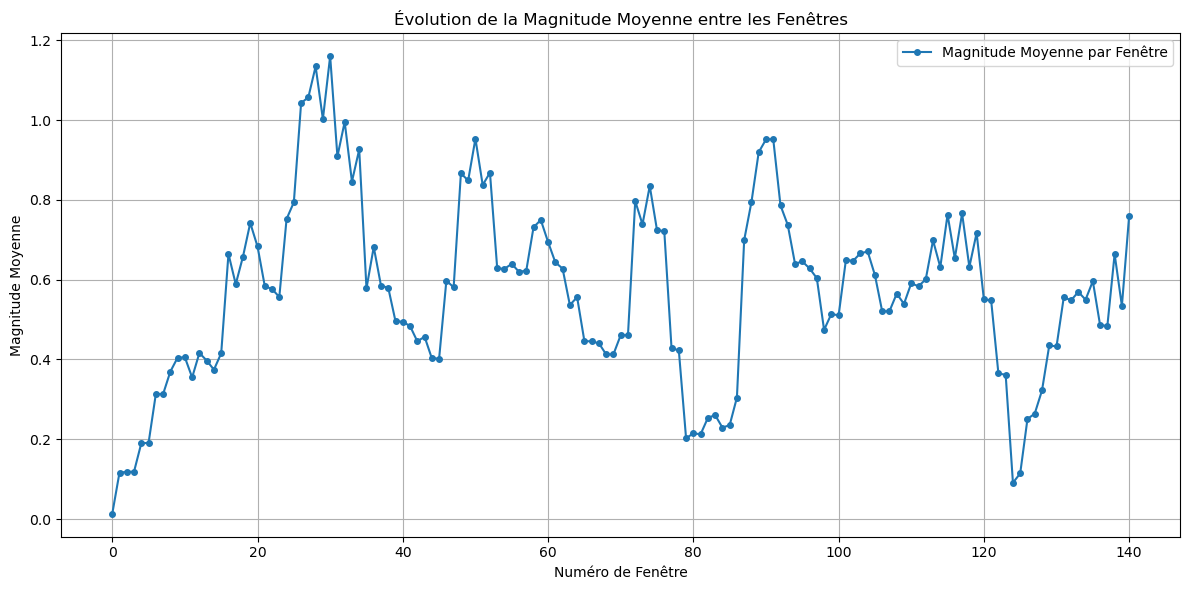

In [10]:
# Calculer la magnitude moyenne pour chaque fenêtre
magnitude_moyenne_par_fenetre = fft_magnitudes.mean(axis=1)

# Tracer l'évolution de la magnitude moyenne entre les fenêtres
plt.figure(figsize=(12, 6))
plt.plot(magnitude_moyenne_par_fenetre, marker='o', linestyle='-', markersize=4, label='Magnitude Moyenne par Fenêtre')
plt.xlabel('Numéro de Fenêtre')
plt.ylabel('Magnitude Moyenne')
plt.title('Évolution de la Magnitude Moyenne entre les Fenêtres')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

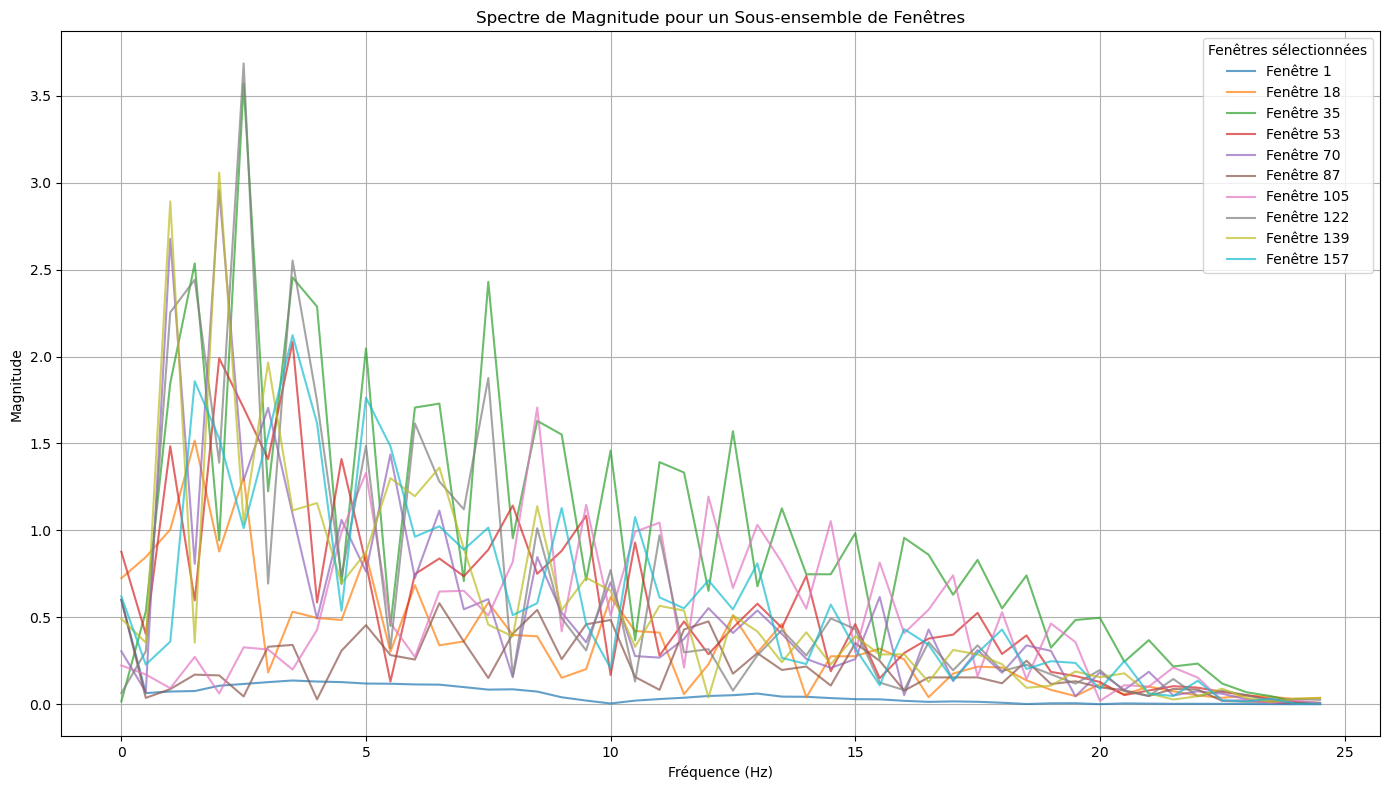

In [7]:
# Sélectionner un sous-ensemble représentatif de fenêtres pour la visualisation
# Pour éviter la surcharge graphique, sélectionnons environ 10 fenêtres espacées uniformément à travers le dataset
indices_fenetres = np.linspace(0, len(fft_magnitudes) - 1, 10, dtype=int)

plt.figure(figsize=(14, 8))

# Tracer les spectres de magnitude pour le sous-ensemble de fenêtres sélectionnées
for index in indices_fenetres:
    plt.plot(frequences, fft_magnitudes.iloc[index], label=f'Fenêtre {index+1}', alpha=0.7)

plt.xlabel('Fréquence (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectre de Magnitude pour un Sous-ensemble de Fenêtres')
plt.legend(title="Fenêtres sélectionnées")
plt.grid(True)
plt.tight_layout()

In [8]:
# Calculer les caractéristiques fréquentielles
mean_frequency = np.mean(fft_magnitudes, axis=1)
min_frequency = np.min(fft_magnitudes, axis=1)
std_frequency = np.std(fft_magnitudes, axis=1)

In [9]:
# Créer un dataframe pour stocker les caractéristiques fréquentielles
features_df = pd.DataFrame({
    'mean_frequency': mean_frequency,
    'min_frequency': min_frequency,
    'std_frequency': std_frequency
})

#### entropie spectrale de puissance

In [24]:
# import entropy as ent
# # Fonction pour calculer l'entropie spectrale pour chaque ligne
# def calculate_spectral_entropy(signal_frequencies):
#     entropies = []
#     for row in signal_frequencies:
#         entropy = ent.spectral_entropy(row, 50, method='fft')
#         entropies.append(entropy)
#     return entropies

# # Exemple d'utilisation
# # Supposez que vous avez un tableau de fréquences 'signal_frequencies' après la transformée de Fourier
# # 'signal_frequencies' est un tableau contenant les valeurs du signal dans le domaine fréquentiel, où chaque ligne représente une fenêtre de données

# # Calculer l'entropie spectrale pour chaque ligne
# entropies = calculate_spectral_entropy(fft_magnitudes)

In [7]:
def calcul_entropie_spectrale (fft_magnitudes):
    # Calculer l'entropie spectrale de puissance pour chaque fenêtre
    entropie_spectrale = []

    for index, row in fft_magnitudes.iterrows():
        # Calculer les proportions pi de la puissance spectrale
        puissance_totale = np.sum(row**2)
        p_i = (row**2) / puissance_totale
    
        # Filtrer les valeurs de p_i égales à 0 pour éviter les erreurs de log(0)
        p_i = p_i[p_i > 0]

        # Calculer l'entropie spectrale pour la fenêtre actuelle
        H = -np.sum(p_i * np.log(p_i))
        entropie_spectrale.append(H)

    # Convertir la liste d'entropie en un tableau numpy pour une manipulation facile
    entropie_spectrale = np.array(entropie_spectrale)
    return entropie_spectrale

entropie_spectrale = calcul_entropie_spectrale(fft_magnitudes)

#### Première et deuxième harmonique, fréquence qui sépare les deux pics et centre de densité spectrale, crête spectrale de puissance

In [12]:
def calcul_details_harmoniques (fft_magnitudes, frequencies):

    # Initialiser les listes pour stocker les résultats
    premiere_harmonique_mag = []
    deuxieme_harmonique_mag = []
    premiere_harmonique_freq = []
    deuxieme_harmonique_freq = []
    distance_harmonique_frequence = []  # Liste pour stocker la distance entre les harmoniques
    distance_harmonique_magnitude = []
    centre_densite_spectrale = []
    centre_densite_spectrale_puissance = []
    rapport_harmonique_frequence = []
    rapport_harmonique_magnitude = []
    crete_spectrale_puissance_ponderee_gpt = []
    crete_spectrale_puissance_ponderee_borzi = []
    largeurs_harmoniques = []


    # Itérer sur chaque fenêtre
    for index, row in fft_magnitudes.iterrows():
        magnitudes = row.values
        frequences = frequencies.values.flatten() # Assumer que les fréquences sont constantes et identiques pour toutes les fenêtres
    
        # Trouver les indices des deux plus grandes magnitudes
        indices_harmoniques = np.argsort(magnitudes)[-2:]  # Cela nous donne les indices du second puis du premier
    
        # Assurer que l'indice de la première harmonique est celui de la plus grande magnitude
        if magnitudes[indices_harmoniques[0]] > magnitudes[indices_harmoniques[1]]:
            premiere_harmonique, deuxieme_harmonique = indices_harmoniques[0], indices_harmoniques[1]
        else:
            premiere_harmonique, deuxieme_harmonique = indices_harmoniques[1], indices_harmoniques[0]
    
        # Calculer le centre de densité spectrale (CDS)
        cds = np.sum(frequences * magnitudes) / np.sum(magnitudes)
    
        # Calculer le centre de densité spectrale de puissance
        cds_puissance = np.sum(frequences * magnitudes**2) / np.sum(magnitudes**2)
    
        # Calcul de la crête spectrale de puissance pondérée selon GPT
        cs_puissance_ponderee_gpt = np.max(magnitudes**2) / np.sum(magnitudes**2)
    
        # Calcul de la crête spectrale de puissance pondérée selon Borzi
        cs_puissance_ponderee_borzi = ((magnitudes[premiere_harmonique]**2) * frequences[premiere_harmonique])
    
        # Stocker les résultats
        premiere_harmonique_mag.append(magnitudes[premiere_harmonique])
        deuxieme_harmonique_mag.append(magnitudes[deuxieme_harmonique])
        premiere_harmonique_freq.append(frequences[premiere_harmonique])
        deuxieme_harmonique_freq.append(frequences[deuxieme_harmonique])
        centre_densite_spectrale.append(cds)
        centre_densite_spectrale_puissance.append(cds_puissance)
        crete_spectrale_puissance_ponderee_gpt.append(cs_puissance_ponderee_gpt)
        crete_spectrale_puissance_ponderee_borzi.append(cs_puissance_ponderee_borzi)
    
        # Calculer et stocker la distance de fréquence entre les harmoniques
        distance_harmonique_frequence.append(abs(frequences[premiere_harmonique] - frequences[deuxieme_harmonique]))
    
    
        # Pour éviter Inf, vérifier si le dénominateur est zéro
        if frequences[deuxieme_harmonique] == 0:
            rapport_harmonique_frequence.append(0)
        else:
            rapport_harmonique_frequence.append(frequences[premiere_harmonique] / frequences[deuxieme_harmonique])
    
    
        # Calculer et stocker la distance de magnitude entre les harmoniques
        distance_harmonique_magnitude.append(abs(magnitudes[premiere_harmonique] - magnitudes[deuxieme_harmonique]))
    
        # De même, éviter Inf pour les magnitudes
        if magnitudes[deuxieme_harmonique] == 0:
            rapport_harmonique_magnitude.append(0)
        else:
            rapport_harmonique_magnitude.append(magnitudes[premiere_harmonique] / magnitudes[deuxieme_harmonique])
        
        
           
        # Calculer la largeur des harmoniques
            # Calculer la magnitude de la première harmonique
        premiere_harmonique_magnitude = magnitudes[premiere_harmonique]
    
        # Utiliser la bonne méthode pour trouver les indices gauche et droite
        # Trouver l'indice de gauche
        gauche = np.where(magnitudes[:premiere_harmonique] < premiere_harmonique_magnitude * 0.5)[0]
        if len(gauche) > 0:
            indice_gauche = gauche[-1] + 1  # Prendre le dernier indice sous le seuil et ajouter 1
        else:
            indice_gauche = 0  # S'il n'y a pas de valeur sous le seuil, prendre le début du signal
    
        # Trouver l'indice de droite
        droite = np.where(magnitudes[premiere_harmonique+1:] < premiere_harmonique_magnitude * 0.5)[0]
        if len(droite) > 0:
            indice_droite = droite[0] + premiere_harmonique + 1  # Prendre le premier indice sous le seuil après le pic
        else:
            indice_droite = len(magnitudes) - 1  # S'il n'y a pas de valeur sous le seuil, prendre la fin du signal
    
        # Calculer la largeur en Hz
        largeur_hz = frequences[indice_droite] - frequences[indice_gauche]
        largeurs_harmoniques.append(largeur_hz)

    # Créer un DataFrame pour les résultats
    df_resultats = pd.DataFrame({
        'Premiere_Harmonique_Magnitude': premiere_harmonique_mag,
        'Deuxieme_Harmonique_Magnitude': deuxieme_harmonique_mag,
        'Premiere_Harmonique_Frequence': premiere_harmonique_freq,
        'Deuxieme_Harmonique_Frequence': deuxieme_harmonique_freq,
        'Distance_Harmonique_Frequence': distance_harmonique_frequence,
        'Distance_Harmonique_Amplitude':  distance_harmonique_magnitude,
        'Rapport_Harmonique_Frequence': rapport_harmonique_frequence,
        'Rapport_Harmonique_Amplitude':  rapport_harmonique_magnitude,
        'Centre_Densite_Spectrale': centre_densite_spectrale,
        'Centre_Densite_Spectrale_Puissance': centre_densite_spectrale_puissance,
        'Crete_Spectrale_Puissance_Ponderee_GPT': crete_spectrale_puissance_ponderee_gpt,
        'Crete_Spectrale_Puissance_Ponderee_Borzi': crete_spectrale_puissance_ponderee_borzi,
        'Largeur_Harmonique': largeurs_harmoniques
        })
    
    return premiere_harmonique_mag,deuxieme_harmonique_mag,premiere_harmonique_freq,deuxieme_harmonique_freq, distance_harmonique_frequence,distance_harmonique_magnitude,rapport_harmonique_frequence,rapport_harmonique_magnitude, centre_densite_spectrale,centre_densite_spectrale_puissance, crete_spectrale_puissance_ponderee_gpt, crete_spectrale_puissance_ponderee_borzi, largeurs_harmoniques

# # Afficher les premières lignes du DataFrame résultant pour vérification
# print(df_resultats.head())
df_resultats = calcul_details_harmoniques(fft_magnitudes, frequencies)


# ________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

In [11]:
# # Créer un DataFrame pour les résultats
# df_resultats = pd.DataFrame({
#     'Mean_Frequency': mean_frequency,
#     'Min_Frequency': min_frequency,
#     'Std_Frequency': std_frequency,
#     'Entropie_Spectrale': entropie_spectrale,
#     'Premiere_Harmonique_Magnitude': premiere_harmonique_mag,
#     'Deuxieme_Harmonique_Magnitude': deuxieme_harmonique_mag,
#     'Premiere_Harmonique_Frequence': premiere_harmonique_freq,
#     'Deuxieme_Harmonique_Frequence': deuxieme_harmonique_freq,
#     'Distance_Harmonique_Frequence': distance_harmonique_frequence,
#     'Distance_Harmonique_Amplitude':  distance_harmonique_magnitude,
#     'Rapport_Harmonique_Frequence': rapport_harmonique_frequence,
#     'Rapport_Harmonique_Amplitude':  rapport_harmonique_magnitude,
#     'Centre_Densite_Spectrale': cds_list
# })

## Ecart type

In [10]:
def ecart_type_borne (fft_magnitudes, frequences):
    # Définissons les bandes de fréquences spécifiées
    bandes_frequence = {
        'ecart_type': (0, 50),
        'ecart_type_0.04_0.68_Hz': (0.04, 0.68),
        'ecart_type_0.68_3_Hz': (0.68, 3),
        'ecart_type_3_8_Hz': (3, 8),
        'ecart_type_8_20_Hz': (8, 20),
        'ecart_type_0.1_8_Hz': (0.1, 8)
    }

    # Extrayons les fréquences depuis le fichier frequence.csv pour l'associer à chaque colonne de magnitude_frequence.csv
    frequences = frequencies.values.flatten()

    # Créons un DataFrame pour stocker les écarts types calculés pour chaque bande de fréquence et pour chaque ligne (fenêtre)
    ecarts_types = pd.DataFrame()

    # Pour chaque bande de fréquence, filtrons les données et calculons l'écart type
    for nom_bande, (freq_min, freq_max) in bandes_frequence.items():
    
        # Identifions les colonnes correspondant à la bande de fréquence
        colonnes_bande = (frequences >= freq_min) & (frequences <= freq_max)
    
        # Filtrons les magnitudes pour cette bande de fréquence
        magnitudes_bande = fft_magnitudes.loc[:, colonnes_bande]
    
        # Calculons l'écart type pour cette bande de fréquence et ajoutons les résultats au DataFrame
        ecarts_types[nom_bande] = magnitudes_bande.std(axis=1)
        
    return ecarts_types

# # # Affichons les premières lignes des résultats pour vérifier
ecarts_type = ecart_type_borne(fft_magnitudes, frequencies)

## Freeze Index

In [15]:
def calculer_freeze_index(magnitudes, frequences):
    """
    Calcule le Freeze Index pour chaque fenêtre de données.
    
    :param magnitudes: Un DataFrame ou un numpy array des magnitudes du spectre de puissance pour chaque fenêtre.
    :param frequences: Un numpy array des fréquences correspondant aux colonnes de magnitudes.
    :return: Un numpy array contenant le Freeze Index pour chaque fenêtre.
    """
    
    # Définissons une fonction interne pour calculer l'aire sous le spectre de puissance
    def calculer_aire_sous_spectre(frequences, magnitudes, freq_min, freq_max):
        indices_bande = (frequences >= freq_min) & (frequences <= freq_max)
        magnitudes_bande = magnitudes[:, indices_bande]
        aire_sous_spectre = np.trapz(magnitudes_bande, x=frequences[indices_bande], axis=1)
        return aire_sous_spectre

    # Bandes de fréquences pour le Freeze Index
    bande_freeze = (3, 8)  # Bande "freeze"
    bande_locomotrice = (0.5, 3)  # Bande "locomotrice"

    # Calcul de l'aire sous le spectre pour chaque bande
    aire_freeze = calculer_aire_sous_spectre(frequences, magnitudes, *bande_freeze)
    aire_locomotrice = calculer_aire_sous_spectre(frequences, magnitudes, *bande_locomotrice)

    # Calcul du Freeze Index
    freeze_index = (aire_freeze ** 2) / (aire_locomotrice ** 2)

    return freeze_index

# Exemple d'utilisation de la fonction `calculer_freeze_index`
# Assurez-vous que `magnitude_frequence_df` et `frequences` sont définis et chargés correctement
magnitudes = fft_magnitudes.values  # Convertissons le DataFrame en numpy array si ce n'est pas déjà le cas
frequences = frequencies.values.flatten()

# Calculons le Freeze Index
freeze_index_resultats = calculer_freeze_index(magnitudes, frequences)

# # Créons un DataFrame pour afficher les Freeze Index calculés
# freeze_index_df = pd.DataFrame({'Freeze Index': freeze_index_resultats})

# # Affichage des premiers résultats
# print(freeze_index_df.head())

[0.12687507 0.13633949 0.13027695 0.12706876 0.11874343 0.11770188
 0.11367508 0.1123753  0.09835782 0.08380812 0.08559143]
[0.06385534 0.07282656 0.0757004  0.10609491 0.1163463  0.12687507]


## Fréquence de faible Puissance pour une bande fréquence entre 0 et 2 Hz

In [13]:
## Fréquence de faible Puissance pour une bande fréquence entre 0 et 2 Hz
def ratio_faible_puissance_entre_0_2Hz (fft_magnitudes,frequencies):
    # Assurez-vous que `magnitude_frequence_df` et `frequences` sont définis et chargés correctement
    magnitudes = fft_magnitudes.values  # Convertissons le DataFrame en numpy array si ce n'est pas déjà le cas
    frequences = frequencies.values.flatten()

    ratios = []  # Pour stocker le ratio de chaque fenêtre
    psd = np.abs(magnitudes)**2  # Calcul de la densité spectrale de puissance
    puissance_totale = np.sum(psd, axis=1)  # Calcul de la puissance totale du signal pour chaque fenêtre
    
    # Filtrer pour obtenir la puissance dans la bande 0-2 Hz
    bande_indices = (frequences >= 0) & (frequences <= 2)
    psd_band= psd[:, bande_indices]
    puissance_bande = np.sum(psd_band, axis = 1)
        
    # Calculer le ratio pour la fenêtre
    for fenetre in magnitudes:
        ratio_puissance_bande = puissance_bande / puissance_totale
        ratios.append(ratio_puissance_bande)
        
    return ratios

# Exemple d'utilisation de la fonction `ratio_faible_puissance_entre_0_2Hz`
ratios = ratio_faible_puissance_entre_0_2Hz(fft_magnitudes, frequencies)


##  Skewness (sans fréquence spécifique et entre 0,04–0,68 Hz / 0,68–3 Hz / 3–8 Hz / 8–20 Hz et 0,1–8 H)

In [13]:
def skewness_band_freq (fft_magnitudes,frequencies):
    magnitudes = fft_magnitudes.values  # Convertissons le DataFrame en numpy array si ce n'est pas déjà le cas
    frequences = frequencies.values.flatten()


    # Définissons les bandes de fréquences spécifiées
    bandes_frequence = {
        'skewness': (0, 50),
        'skewness_0.04_0.68_Hz': (0.04, 0.68),
        'skewness_0.68_3_Hz': (0.68, 3),
        'skewness_3_8_Hz': (3, 8),
        'skewness_8_20_Hz': (8, 20),
        'skewness_0.1_8_Hz': (0.1, 8)
    }

    # Créons un DataFrame pour stocker les écarts types calculés pour chaque bande de fréquence et pour chaque ligne (fenêtre)
    skwenesss = pd.DataFrame()

    # Pour chaque bande de fréquence, filtrons les données et calculons l'écart type
    for nom_bande, (freq_min, freq_max) in bandes_frequence.items():
    
        # Identifions les colonnes correspondant à la bande de fréquence
        colonnes_bande = (frequences >= freq_min) & (frequences <= freq_max)
    
        # Filtrons les magnitudes pour cette bande de fréquence
        magnitudes_bande = magnitudes[:, colonnes_bande]
    
        # Calculons l'écart type pour cette bande de fréquence et ajoutons les résultats au DataFrame
        skwenesss[nom_bande] = skew(magnitudes_bande,axis=1)

    # Affichons les premières lignes des résultats pour vérifier
    skwenesss.head()
    return skwenesss

skewnesss = skewness_band_freq(fft_magnitudes, frequencies)
print(skewnesss)


     skewness  skewness_0.04_0.68_Hz  skewness_0.68_3_Hz  skewness_3_8_Hz  \
0    4.449179                    NaN           -0.144054        -0.606654   
1    4.835816                    NaN           -0.166216        -0.673595   
2    6.789190                    NaN           -0.003582         0.046557   
3    6.816067                    NaN            1.137079         0.452747   
4    6.835470                    NaN            0.584252         1.471514   
..        ...                    ...                 ...              ...   
152  0.538150                    NaN           -0.091324        -0.153724   
153  1.156691                    NaN           -0.348070        -0.093647   
154  1.001621                    NaN           -0.351002         0.114202   
155  1.113339                    NaN           -0.661426         0.326506   
156  1.057754                    NaN           -0.676994         0.176146   

     skewness_8_20_Hz  skewness_0.1_8_Hz  
0            0.757240          -

C:\Users\antho\AppData\Local\Temp\ipykernel_11008\3675844528.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skwenesss[nom_bande] = skew(magnitudes_bande,axis=1)


## Kurtosis (sans fréquence spécifique et entre 0,04–0,68 Hz / 0,68–3 Hz / 3–8 Hz / 8–20 Hz et 0,1–8 H)

In [20]:
def kurtosis_band_freq (fft_magnitudes, frequencies) :
    magnitudes = fft_magnitudes.values  # Convertissons le DataFrame en numpy array si ce n'est pas déjà le cas
    frequences = frequencies.values.flatten()
    # Définissons les bandes de fréquences spécifiées
    bandes_frequence = {
        'kurtosis': (0, 50),
        'kurtosis_0.04_0.68_Hz': (0.04, 0.68),
        'kurtosis_0.68_3_Hz': (0.68, 3),
        'kurtosis_3_8_Hz': (3, 8),
        'kurtosis_8_20_Hz': (8, 20),
        'kurtosis_0.1_8_Hz': (0.1, 8)
    }

    # Créons un DataFrame pour stocker les écarts types calculés pour chaque bande de fréquence et pour chaque ligne (fenêtre)
    kurtosiss = pd.DataFrame()

    # Pour chaque bande de fréquence, filtrons les données et calculons l'écart type
    for nom_bande, (freq_min, freq_max) in bandes_frequence.items():
    
        # Identifions les colonnes correspondant à la bande de fréquence
        colonnes_bande = (frequences >= freq_min) & (frequences <= freq_max)
    
        # Filtrons les magnitudes pour cette bande de fréquence
        magnitudes_bande = magnitudes[:, colonnes_bande]
    
        # Calculons l'écart type pour cette bande de fréquence et ajoutons les résultats au DataFrame
        kurtosiss[nom_bande] = kurtosis(magnitudes_bande,axis=1)

    # Affichons les premières lignes des résultats pour vérifier
    kurtosiss.head()
    
    return kurtosiss

kurtosisss = kurtosis_band_freq(fft_magnitudes,frequencies)
print(kurtosisss)



      kurtosis  kurtosis_0.04_0.68_Hz  kurtosis_0.68_3_Hz  kurtosis_3_8_Hz  \
0    24.215983                    NaN           -1.671515        -0.850036   
1    27.554858                    NaN           -1.570054        -0.473845   
2    44.393058                    NaN           -1.544356        -0.536581   
3    44.643989                    NaN           -0.201988        -0.889676   
4    44.823758                    NaN           -1.051151         0.578461   
..         ...                    ...                 ...              ...   
152  -0.376396                    NaN           -1.725986        -0.769425   
153   0.627404                    NaN           -0.964711        -1.349686   
154   0.545958                    NaN           -0.908322        -0.454235   
155   0.397856                    NaN           -1.070932        -0.832427   
156   0.218089                    NaN           -0.902323        -1.025710   

     kurtosis_8_20_Hz  kurtosis_0.1_8_Hz  
0           -0.02817

C:\Users\antho\AppData\Local\Temp\ipykernel_11008\3151915828.py:27: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosiss[nom_bande] = kurtosis(magnitudes_bande,axis=1)


## Locomotion band power

In [23]:
def calcul_locomotion_band_power (fft_magnitudes,frequencies):
# Locomotion band power
    magnitudes = fft_magnitudes.values  # Convertissons le DataFrame en numpy array si ce n'est pas déjà le cas
    frequences = frequencies.values.flatten()
    # Filtrer pour obtenir la puissance dans la bande de locomotion (0.5-3 Hz)
    bande_locomotion_power_list = []
    psd = np.abs(magnitudes)**2 
    bande_locomotion = (frequences >= 0.5) & (frequences <= 3)
    psd_bande_locomotion = psd[:, bande_locomotion]
    puissance_bande_locomotion = np.sum(psd_bande_locomotion, axis=1)

    for window in puissance_bande_locomotion:
        bande_locomotion_power = window / 50
        bande_locomotion_power_list.append(bande_locomotion_power)
        
    return bande_locomotion_power

bande_locomotion_power = calcul_locomotion_band_power (fft_magnitudes,frequencies)

## Freeze Band Power

In [24]:
def calcul_freeze_band_power (fft_magnitudes,frequencies):
    magnitudes = fft_magnitudes.values  # Convertissons le DataFrame en numpy array si ce n'est pas déjà le cas
    frequences = frequencies.values.flatten()
    # Filtrer pour obtenir la puissance dans la bande de locomotion (3-8 Hz)
    bande_freeze_power_list = []
    psd = np.abs(magnitudes)**2 


    bande_freeze = (frequences >= 3) & (frequences <= 8)
    psd_bande_freeze = psd[:, bande_freeze]
    puissance_bande_freeze = np.sum(psd_bande_freeze, axis=1)

    for window in puissance_bande_freeze:
        bande_freeze_power = window / 50
        bande_freeze_power_list.append(bande_freeze_power)
        
    return bande_freeze_power

## Band power

In [25]:
def calcul_band_power(fft_magnitudes,frequencies):
# Locomotion band power
    magnitudes = fft_magnitudes.values  # Convertissons le DataFrame en numpy array si ce n'est pas déjà le cas
    frequences = frequencies.values.flatten()
    bande_power_list = []
    psd = np.abs(magnitudes)**2 

    # Filtrer pour obtenir la puissance dans la bande de locomotion et de freezing (0.5-8 Hz)
    bande_power = (frequences >= 0.5) & (frequences <= 8)
    psd_bande_power = psd[:, bande_power]
    puissance_bande_power= np.sum(psd_bande_power, axis=1)

    for window in puissance_bande_power:
        bande_power = window / 50
        bande_power_list.append(bande_power)
    return bande_power



# Energie

In [26]:
def calcul_energie (fft_magnitudes, frequencies):
    magnitudes = fft_magnitudes.values  # Convertissons le DataFrame en numpy array si ce n'est pas déjà le cas
    frequences = frequencies.values.flatten()
    energie_liste = []
    
    for window in magnitudes:
        # Calculer l'énergie de la fenêtre comme la somme des carrés des valeurs du signal divisée par la longueur de la fenêtre
        energie = np.sum(np.square(magnitudes)) / len(window)
        energie_liste.append(energie)

# Création de la classe cible (fog et transitionFog) et non cible

In [38]:
def filter_data_by_label(data, label):
    filtered_data = {}

    # Bouclez à travers les données pour chaque muscle, côté, capteur, axe
    for muscle, muscle_data in data.items():
        if muscle not in ["metadata", "parcours", "FOG"]:
            filtered_data[muscle] = {}
            for side, side_data in muscle_data.items():
                filtered_data[muscle][side] = {}
                for sensor, sensor_data in side_data.items():
                    filtered_data[muscle][side][sensor] = {}
                    for axis, axis_data in sensor_data.items():
                        # Filtrer les données pour ne conserver que les lignes avec le label spécifié
                        filtered_df = axis_data[axis_data['label'] == label]
                        # Stockez le DataFrame filtré dans le dictionnaire
                        filtered_data[muscle][side][sensor][axis] = filtered_df

    return filtered_data

In [64]:
def filter_data_by_label(data, target_labels):
    target = {}
    noTarget = {}
    # Bouclez à travers les données pour chaque muscle, côté, capteur, axe
    for muscle, muscle_data in data.items():
        if muscle not in ["metadata", "parcours", "FOG"]:
            target[muscle] = {}
            noTarget[muscle] = {}
            for side, side_data in muscle_data.items():
                target[muscle][side] = {}
                noTarget[muscle][side] = {}
                for sensor, sensor_data in side_data.items():
                    target[muscle][side][sensor] = {}
                    noTarget[muscle][side][sensor] = {}
                    for axis, axis_data in sensor_data.items():
                        # Filtrer les données pour ne conserver que les lignes avec les labels spécifiés
                        target_df = axis_data[axis_data['label'].isin(target_labels)]
                        noTarget_df = axis_data[~axis_data['label'].isin(target_labels)]  # Utilisez ~ pour sélectionner les valeurs qui ne sont pas dans target_labels
                        # Stockez le DataFrame filtré dans le dictionnaire
                        target[muscle][side][sensor][axis] = target_df
                        noTarget[muscle][side][sensor][axis] = noTarget_df

    return target, noTarget


In [65]:
target, noTarget = filter_data_by_label(data, ['fog', 'transitionFog'])

In [66]:
rectus_target = target["Rectus Femoris"]["Left"]["ACC"]["norme"]
rectus_noTarget = noTarget["Rectus Femoris"]["Left"]["ACC"]["norme"]